# Baseline Models (Tolerating Errors)

In [1]:
import numpy as np # Use version 1.x not 2.x
import random
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [2]:
import pickle

def load_data(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)

    records = []
    for company, periods in data.items():
        for period, (features, rating) in periods.items():
            record = {
                'company': company,
                'period': period,
                **{f'feature_{i}': feature.item() for i, feature in enumerate(features)},
                'rating': int(rating.item())
            }
            records.append(record)

    return pd.DataFrame(records)

In [3]:
def plot_grouped_bar_chart(results_df, graph_title='Accuracy at Different Error Thresholds for Various Models'):
    fig, ax = plt.subplots(figsize=(12, 8))
    width = 0.15
    x = np.arange(len(results_df['model']))

    for i, threshold in enumerate(['accuracy_0', 'accuracy_1', 'accuracy_2', 'accuracy_3', 'accuracy_4']):
        ax.bar(x + i * width, results_df[threshold], width, label=f'Error <= {i}')

    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    ax.set_title(graph_title)
    ax.set_xticks(x + width * 2)
    ax.set_xticklabels(results_df['model'])
    ax.legend(title='Error Threshold', loc='upper left', fontsize='small')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Time Window Size = 1

In [4]:
from sklearn.preprocessing import StandardScaler

train_df = load_data('./data/train_dict.pkl')
test_df = load_data('./data/test_dict.pkl')

X_train = train_df.drop(columns=['company', 'period', 'rating'])
y_train = train_df['rating']
X_test = test_df.drop(columns=['company', 'period', 'rating'])
y_test = test_df['rating']

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Regression Models

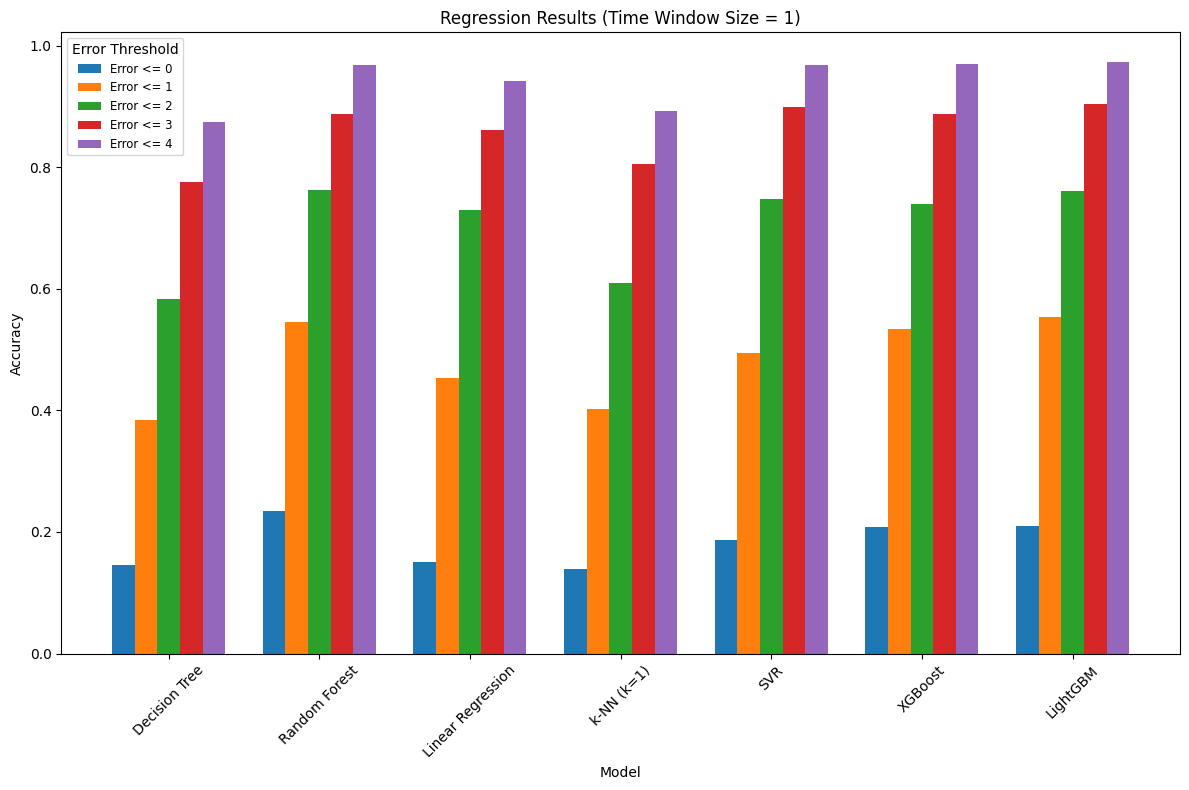

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

models = {
    'Decision Tree': DecisionTreeRegressor(random_state=RANDOM_SEED),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED),
    'Linear Regression': LinearRegression(),
    'k-NN (k=1)': KNeighborsRegressor(n_neighbors=1),
    'SVR': SVR(),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_SEED),
    'LightGBM': lgb.LGBMRegressor(random_state=RANDOM_SEED, verbose=-1)
}

results = {'model': [], 'accuracy_0': [], 'accuracy_1': [], 'accuracy_2': [], 'accuracy_3': [], 'accuracy_4': [], 'mse': []}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_rounded = np.round(y_pred).astype(int)
    y_pred_rounded = np.clip(y_pred_rounded, 0, 23)

    mse = mean_squared_error(y_test, y_pred)
    results['mse'].append(mse)
    
    for threshold in range(5):
        accuracy = np.mean(np.abs(y_test - y_pred_rounded) <= threshold)
        results[f'accuracy_{threshold}'].append(accuracy)

    results['model'].append(model_name)

results_df = pd.DataFrame(results)

plot_grouped_bar_chart(results_df, graph_title='Regression Results (Time Window Size = 1)')

In [6]:
results_df

,model,accuracy_0,accuracy_1,accuracy_2,accuracy_3,accuracy_4,mse
0,Decision Tree,0.145557,0.384831,0.583248,0.775792,0.873851,9.045710
1,Random Forest,0.233912,0.545199,0.763023,0.887130,0.968335,4.874833
2,Linear Regression,0.151430,0.453269,0.729571,0.860572,0.942288,5.714403
3,k-NN (k=1),0.139683,0.401685,0.609551,0.804903,0.891982,8.909602
4,SVR,0.186159,0.494893,0.747957,0.899387,0.967314,4.930915
5,XGBoost,0.208376,0.534474,0.739019,0.888151,0.969867,4.786061
6,LightGBM,0.209397,0.552860,0.761236,0.903728,0.973187,4.618161


### Classification Models

In [7]:
from sklearn.preprocessing import LabelEncoder

def encode_labels(y_train, y_test):
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    
    test_labels = np.unique(y_test)
    new_labels = np.setdiff1d(test_labels, label_encoder.classes_)
    if new_labels.size > 0:
        label_encoder.classes_ = np.append(label_encoder.classes_, new_labels)
    
    y_test_encoded = label_encoder.transform(y_test)
    
    return y_train_encoded, y_test_encoded

In [8]:
y_train, y_test = encode_labels(y_train, y_test)

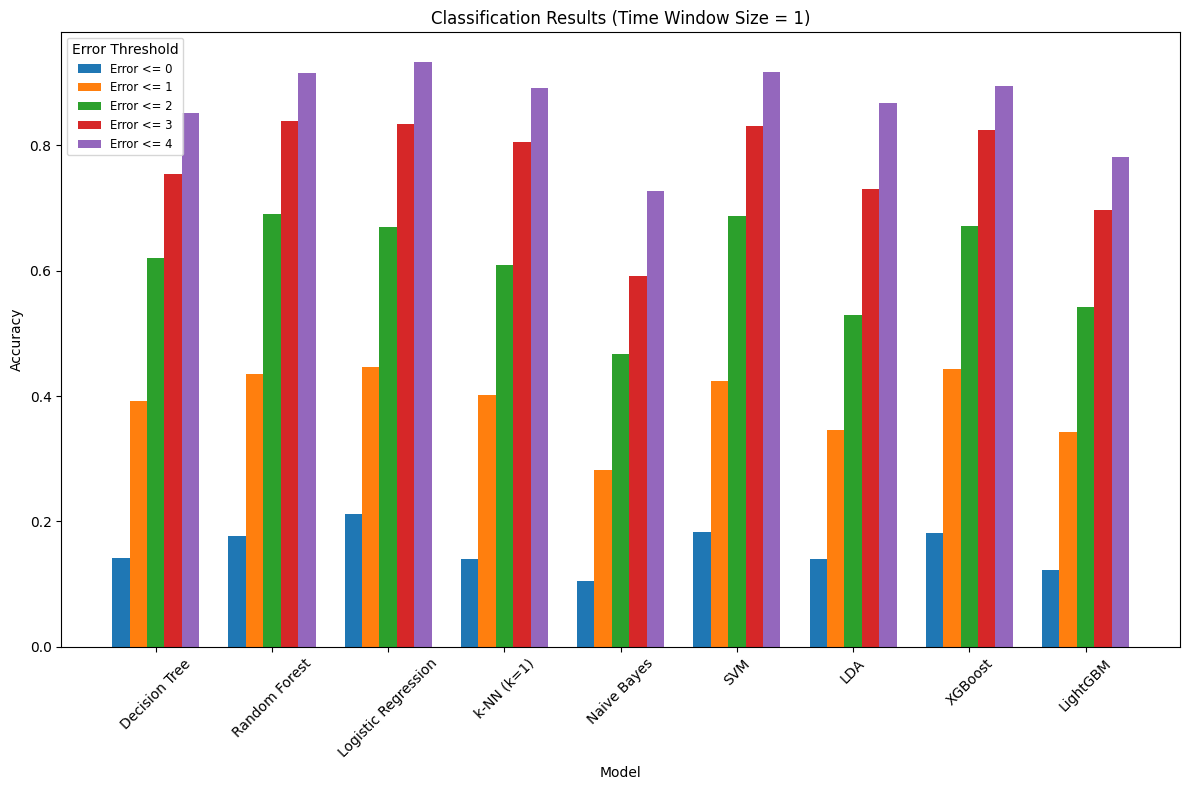

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost as xgb
import lightgbm as lgb

models = {
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_SEED),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED),
    'Logistic Regression': LogisticRegression(max_iter=2000, random_state=RANDOM_SEED),
    'k-NN (k=1)': KNeighborsClassifier(n_neighbors=1),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(random_state=RANDOM_SEED),
    'LDA': LinearDiscriminantAnalysis(),
    'XGBoost': xgb.XGBClassifier(eval_metric='mlogloss', random_state=RANDOM_SEED),
    'LightGBM': lgb.LGBMClassifier(random_state=RANDOM_SEED, verbose=-1)
}

results = {'model': [], 'accuracy_0': [], 'accuracy_1': [], 'accuracy_2': [], 'accuracy_3': [], 'accuracy_4': []}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    for threshold in range(5):
        accuracy = np.mean(np.abs(y_test - y_pred) <= threshold)
        results[f'accuracy_{threshold}'].append(accuracy)

    results['model'].append(model_name)

results_df = pd.DataFrame(results)

plot_grouped_bar_chart(results_df, graph_title='Classification Results (Time Window Size = 1)')

In [10]:
results_df

,model,accuracy_0,accuracy_1,accuracy_2,accuracy_3,accuracy_4
0,Decision Tree,0.141471,0.391471,0.619765,0.753830,0.851634
1,Random Forest,0.177477,0.434883,0.689734,0.838100,0.915220
2,Logistic Regression,0.211696,0.446118,0.669561,0.834270,0.933606
3,k-NN (k=1),0.139683,0.401685,0.609551,0.804903,0.892237
4,Naive Bayes,0.105720,0.282686,0.467314,0.591420,0.727017
5,SVM,0.183861,0.423647,0.687181,0.831461,0.916752
6,LDA,0.140194,0.346272,0.528601,0.730848,0.866956
7,XGBoost,0.181307,0.442799,0.671348,0.823800,0.894791
8,LightGBM,0.122063,0.341931,0.541879,0.697395,0.782176


## Time Window Size = 4

In [11]:
from sklearn.preprocessing import StandardScaler

train_df = load_data('./data/train_dict_windowed.pkl')
test_df = load_data('./data/test_dict_windowed.pkl')

X_train = train_df.drop(columns=['company', 'period', 'rating'])
y_train = train_df['rating']
X_test = test_df.drop(columns=['company', 'period', 'rating'])
y_test = test_df['rating']

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Regression Models

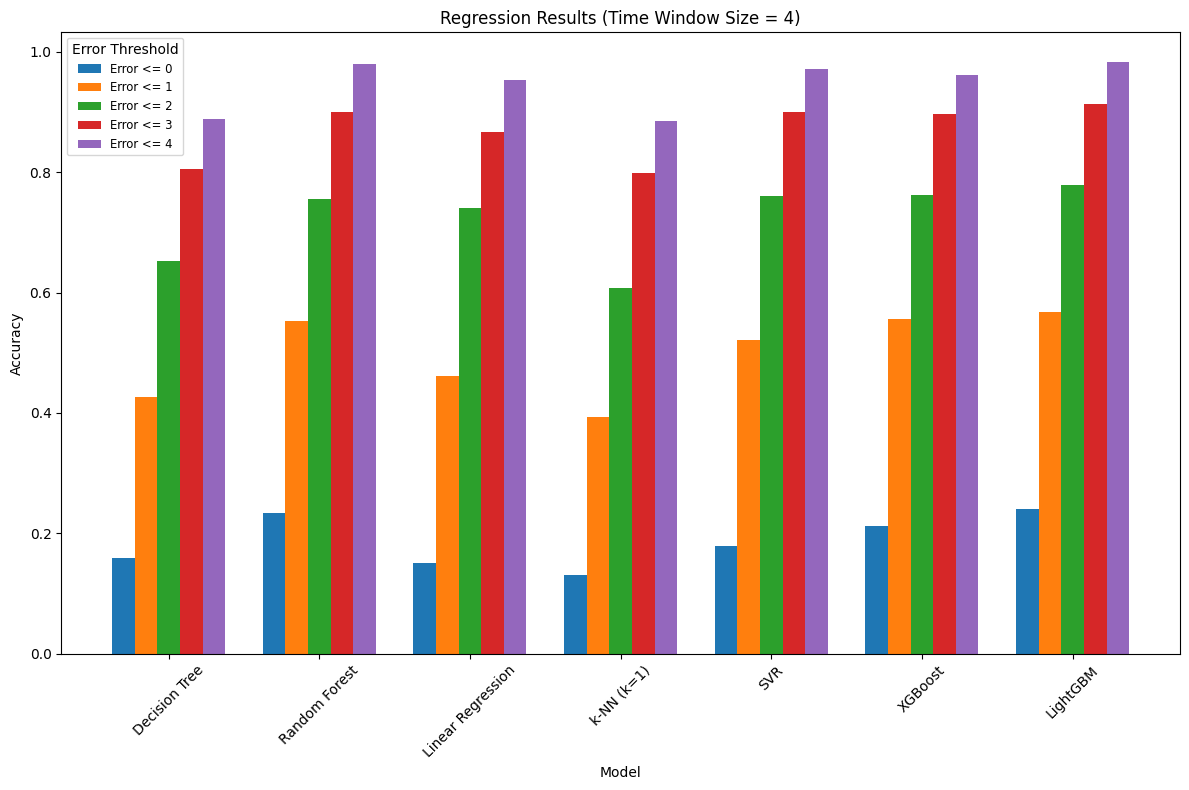

In [12]:
models = {
    'Decision Tree': DecisionTreeRegressor(random_state=RANDOM_SEED),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED),
    'Linear Regression': LinearRegression(),
    'k-NN (k=1)': KNeighborsRegressor(n_neighbors=1),
    'SVR': SVR(),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_SEED),
    'LightGBM': lgb.LGBMRegressor(random_state=RANDOM_SEED, verbose=-1)
}

results = {'model': [], 'accuracy_0': [], 'accuracy_1': [], 'accuracy_2': [], 'accuracy_3': [], 'accuracy_4': [], 'mse': []}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_rounded = np.round(y_pred).astype(int)
    y_pred_rounded = np.clip(y_pred_rounded, 0, 23)

    mse = mean_squared_error(y_test, y_pred)
    results['mse'].append(mse)
    
    for threshold in range(5):
        accuracy = np.mean(np.abs(y_test - y_pred_rounded) <= threshold)
        results[f'accuracy_{threshold}'].append(accuracy)

    results['model'].append(model_name)

results_df = pd.DataFrame(results)

plot_grouped_bar_chart(results_df, graph_title='Regression Results (Time Window Size = 4)')

In [13]:
results_df

,model,accuracy_0,accuracy_1,accuracy_2,accuracy_3,accuracy_4,mse
0,Decision Tree,0.158836,0.426711,0.652707,0.805158,0.888407,7.995659
1,Random Forest,0.233146,0.553371,0.756129,0.899387,0.979826,4.526591
2,Linear Regression,0.149898,0.461440,0.741318,0.866445,0.954035,5.532469
3,k-NN (k=1),0.130746,0.393258,0.608018,0.799540,0.885853,8.791624
4,SVR,0.179009,0.520684,0.761236,0.900409,0.971399,4.646761
5,XGBoost,0.212717,0.556435,0.761747,0.896323,0.961696,4.762830
6,LightGBM,0.240296,0.567416,0.778856,0.913687,0.983401,4.206073


### Classification Models

In [14]:
y_train, y_test = encode_labels(y_train, y_test)

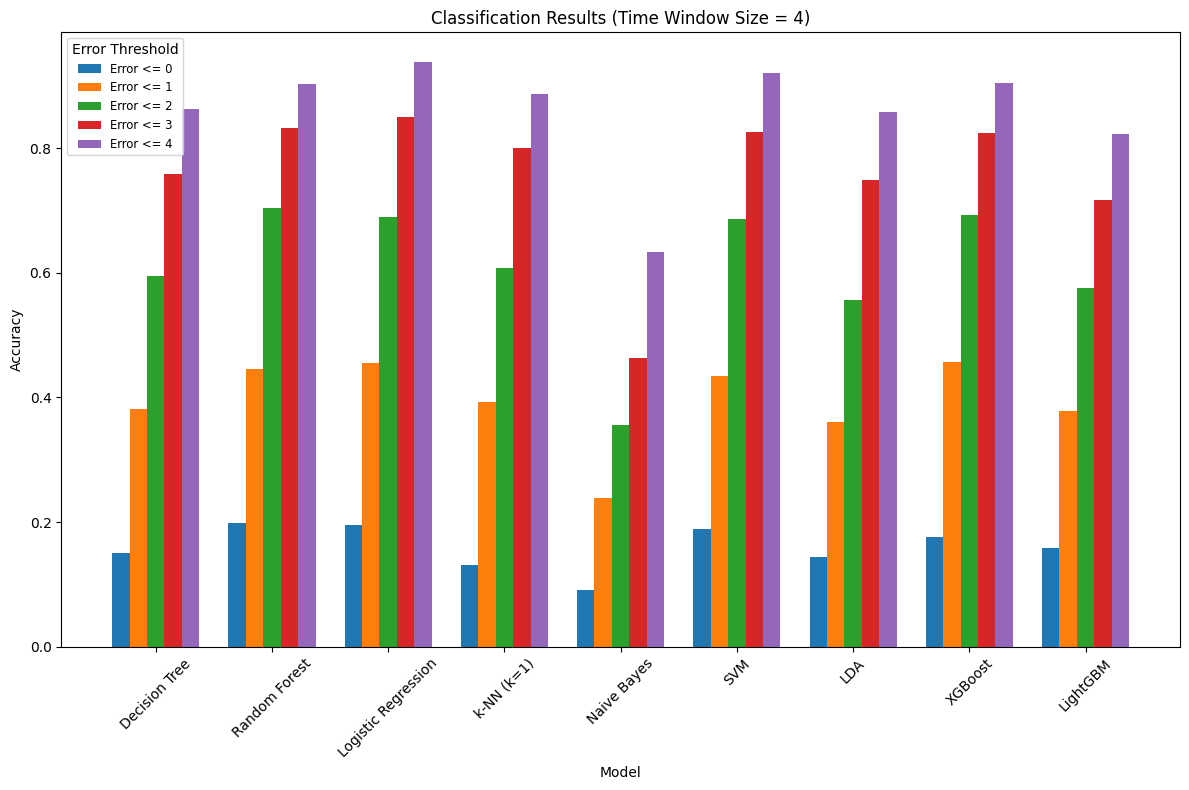

In [15]:
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_SEED),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED),
    'Logistic Regression': LogisticRegression(max_iter=2000, random_state=RANDOM_SEED),
    'k-NN (k=1)': KNeighborsClassifier(n_neighbors=1),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(random_state=RANDOM_SEED),
    'LDA': LinearDiscriminantAnalysis(),
    'XGBoost': xgb.XGBClassifier(eval_metric='mlogloss', random_state=RANDOM_SEED),
    'LightGBM': lgb.LGBMClassifier(random_state=RANDOM_SEED, verbose=-1)
}

results = {'model': [], 'accuracy_0': [], 'accuracy_1': [], 'accuracy_2': [], 'accuracy_3': [], 'accuracy_4': []}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    for threshold in range(5):
        accuracy = np.mean(np.abs(y_test - y_pred) <= threshold)
        results[f'accuracy_{threshold}'].append(accuracy)

    results['model'].append(model_name)

results_df = pd.DataFrame(results)

plot_grouped_bar_chart(results_df, graph_title='Classification Results (Time Window Size = 4)')

In [16]:
results_df

,model,accuracy_0,accuracy_1,accuracy_2,accuracy_3,accuracy_4
0,Decision Tree,0.150153,0.381001,0.595250,0.758172,0.863126
1,Random Forest,0.197906,0.445608,0.703524,0.832227,0.902196
2,Logistic Regression,0.195863,0.455567,0.688713,0.850358,0.938713
3,k-NN (k=1),0.130746,0.393258,0.608018,0.799540,0.886364
4,Naive Bayes,0.091675,0.237998,0.356231,0.463994,0.633299
5,SVM,0.188458,0.433606,0.686925,0.826353,0.920838
6,LDA,0.144025,0.360572,0.555669,0.748212,0.857763
7,XGBoost,0.176200,0.456588,0.692288,0.824311,0.903984
8,LightGBM,0.159091,0.378958,0.575332,0.716037,0.822523
